# 1. load datasets

In [40]:
from sklearn.datasets import fetch_mldata
import numpy as np
mnist = fetch_mldata('MNIST original')

In [41]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [42]:
X, y = mnist["data"], mnist["target"]

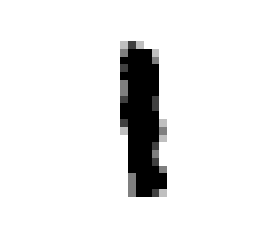

1.0


In [179]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[10050]
def plot_digit(some_digit):
    some_digit_image = some_digit.reshape(28, 28)
    plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()
plot_digit(some_digit)
print(y[10050])

In [44]:
# split training and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [45]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 2. Train a binary classifer

In [46]:
from sklearn.linear_model import SGDClassifier
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [47]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [48]:
sgd_clf.predict(X_test)[1000]

False

In [49]:
y_test_5[1000]

False

# 3. Evaluate Model Performance

In [50]:
# 1. accuracy, cross_val_score

In [51]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.9502, 0.96565 and 0.96495

0
0
0


In [52]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9503 ,  0.96065,  0.95365])

In [53]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [54]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9104 ,  0.9095 ,  0.90905])

In [55]:
# 2. confusion matrix

In [56]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [57]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
confusion_matrix(y_train_5, y_train_pred)

array([[53624,   955],
       [ 1753,  3668]])

In [58]:
precision_score(y_train_5, y_train_pred)

0.79342418343067267

In [59]:
recall_score(y_train_5, y_train_pred)

0.67662792842648956

In [60]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.73038630027877338

In [61]:
# 3. trade off Precision and recall

In [63]:
some_digit = X_test[1000]
y_scores = sgd_clf.decision_function([some_digit])

In [78]:
y_test_5[1000]

False

In [89]:
y_scores[1000] < 0

array([False,  True], dtype=bool)

In [84]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [85]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores[:, 1])

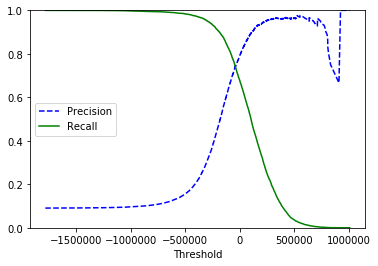

In [91]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [104]:
y_train_pred_90 = (y_scores > 70000)[:, 1]
y_train_pred_90.shape

(60000,)

In [109]:
precision_score(y_train_5, y_train_pred_90)

0.86727688787185353

In [108]:
recall_score(y_train_5, y_train_pred_90)

0.55930640103301976

In [110]:
# 4. ROC Curve

In [111]:
from sklearn.metrics import roc_curve

In [113]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores[:, 1])

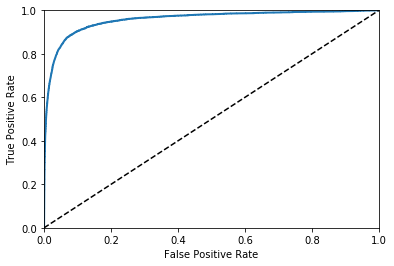

In [115]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr, label="roc curve")
plt.show()

In [117]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_train_5, y_scores[:, 1])
auc_score

0.95790534741321021

In [119]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [124]:
y_probas_forest.shape

(60000,)

In [125]:
y_scores_forest = y_probas_forest

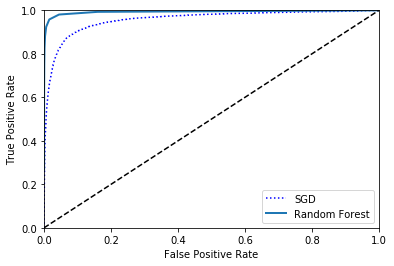

In [128]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [129]:
roc_auc_score(y_train_5, y_scores_forest)

0.99326315133999887

# 4. Multi Class Classification

In [130]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [143]:
scores = sgd_clf.predict(X_test)
scores[900]

0.0

In [146]:
np.argmax(sgd_clf.decision_function(X_test)[900])

8840

In [148]:
sgd_clf.classes_[6]

6.0

In [149]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))

In [150]:
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
          n_jobs=1)

In [151]:
ovo_clf.predict(X_test)

array([ 0.,  0.,  0., ...,  9.,  9.,  9.])

In [153]:
len(ovo_clf.estimators_)

45

In [159]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [160]:
forest_clf.predict_proba([some_digit])

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [161]:
cross_val_score(sgd_clf, X_train, y_train, cv=4, scoring="accuracy")

array([ 0.86031323,  0.87301693,  0.84437925,  0.88056019])

In [162]:
# improve accuracy with standard scaler

In [163]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=4, scoring="accuracy")

array([ 0.91189603,  0.90787895,  0.91138819,  0.90936979])

# 5. Error Analysis

In [164]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [165]:
conf_metrix = confusion_matrix(y_train, y_train_pred)

In [166]:
conf_metrix.shape

(10, 10)

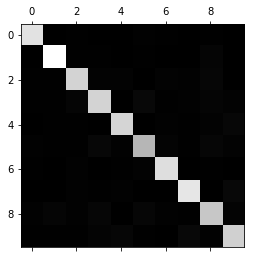

In [167]:
plt.matshow(conf_metrix, cmap=plt.cm.gray)
plt.show()

In [175]:
row_sums = conf_metrix.sum(axis=1, keepdims=True)


In [173]:
norm_conf_metrix = conf_metrix / row_sums

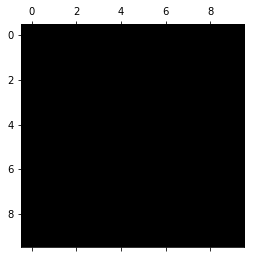

In [174]:
np.fill_diagonal(norm_conf_metrix, 0)
plt.matshow(norm_conf_metrix, cmap=plt.cm.gray)
plt.show()

NameError: name 'plot_digits' is not defined

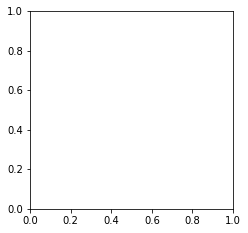

In [180]:
## plot 3 and 5
%matplotlib inline
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 6. Multilabel Classification

In [185]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [186]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [187]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [ ]:
y_train_knn_predict = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# 7. Multioutput Classification

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)